In [20]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import os
import glob
import mplniw.utils as ut
from scipy import signal
#import mitequinox.sigp as sp


In [2]:
root_dir = '/Users/zcasparcohen/Documents/NISKINE/data/'

In [32]:
def convolve(x, h=None, hilbert=False):
    """ Convolve an input signal with a kernel
    Optionaly compute the Hilbert transform of the resulting time series
    
    Parameters
    x : input signal
    h : filter 
    hilbert : True for Hilbert transform to be applied to the filtered signal
    
    Returns
    x_f : filtered signal or hilbert transform of the filtered signal
    """
    x_f = signal.filtfilt(h, [1], x, axis=-1,padlen=30)#
    if hilbert:
        return signal.hilbert(x_f)
    else:
        return x_f

def filt(v, h, hilbert=False):
    
    output_dtype = complex if hilbert else float
    gufunc_kwargs = dict(output_sizes={'time': len(v.time)})
    return xr.apply_ufunc(convolve, v, kwargs={'h': h, 'hilbert': hilbert},
                    dask='parallelized', output_dtypes=[output_dtype],
                    input_core_dims=[['time']],
                    output_core_dims=[['time']],
                    dask_gufunc_kwargs = gufunc_kwargs,
                         )

In [33]:
mooring='M1'
ds_locations = xr.open_dataset(root_dir+'niskine_mooring_locations.nc')
ds_gridded = xr.open_dataset(root_dir+'gridded/'+mooring+'_gridded_simple_merge_gaps_filled.nc')

In [47]:
lat = ds_locations.sel(mooring=1).lat_actual.values
f = ut.coriolis(lat)
fcpd = f*3600*24/(2*np.pi)
Tw = 10
dband = 0.2
dt = 1/(24*6)

In [48]:
#om,Tw,dband,V = omega,Tw,dband,V #define parameters needed in wrap_filter
h = ut.generate_filter(fcpd, T=Tw, dt=dt, bandwidth=dband, normalized_bandwidth=None)
def wrap_filter(_ds,dt=dt):
    time = np.arange(0,_ds['time'].values.size*dt,dt)
    exp = np.exp(-1j*om*2*np.pi*time)
#    _ds = ut._reset_chunk_encoding(_ds)
#    _ds = _ds.chunk(dict(time=-1,i=100,j=100))
    ds_hat={}
    for v in V:
        ds_hat[v+'_hat'] = filt(_ds[v], h,hilbert=True)#.persist()
        ds_hat[v+'_hat_real'] = ds_hat[v+'_hat'].real
        ds_hat[v+'_hat_imag'] = ds_hat[v+'_hat'].imag
#        ds_hat[v+'_hat'] = ds_hat[v+'_hat'].assign_coords({'lon':ds_hat[v+'_hat'].lon,'lat':ds_hat[v+'_hat'].lat})
        ds_hat[v+'_demodulated'] = ds_hat[v+'_hat']*exp
        ds_hat[v+'_demodulated_real'] = ds_hat[v+'_demodulated'].real
        ds_hat[v+'_demodulated_imag'] = ds_hat[v+'_demodulated'].imag
    ds_hat = xr.merge([ds_hat[v].rename(v) for v in ds_hat.keys()])#.drop([v+'_hat',v+'_demodulated'])
#    ds_hat = ds_hat.chunk(dict(i=100)) #,j=4320//4
    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat#.drop(['XC','YC'])

def wrap_filter_low(_ds,dt=dt):
    h = signal.firwin(T*24, cutoff=[omega], pass_zero=True, nyq=1./2/dt, scale=True)
    ds_hat = filt(_ds[v], h,hilbert=False)#.persist()
    ds_hat = ds_hat.rename(v+'_hat').to_dataset()
#    ds_hat = ds_hat.chunk(dict(i=4320//4,j=4320//4))
#    ds_hat = ut._reset_chunk_encoding(ds_hat)
    return ds_hat

In [52]:
ds_filtered = filt(ds_gridded.u,h,axis=0)

TypeError: filt() got an unexpected keyword argument 'axis'

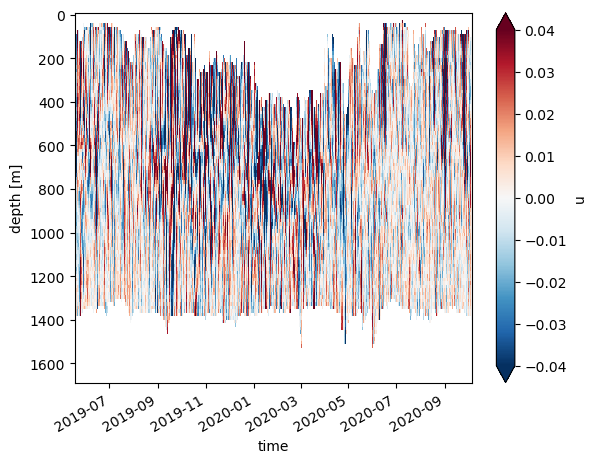

In [51]:
ds_filtered.plot(yincrease=False,vmax=0.04)

In [61]:
_ = signal.filtfilt(h,[1],ds_gridded.u,axis=-1,padlen=100)

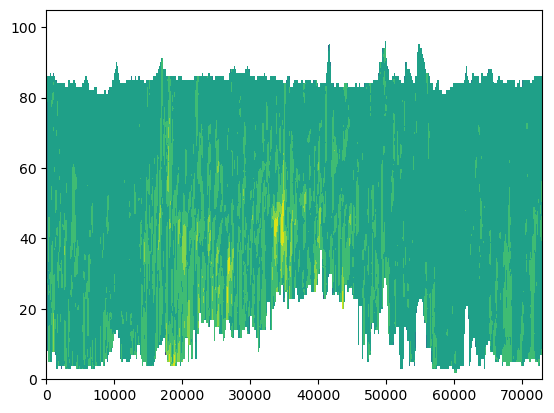

In [62]:
plt.contourf(_)